In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
import matplotlib as mpl
from glob import glob
from copy import copy

%matplotlib widget

In [ ]:
s21 = np.load('./S21s/LT343/VNAsweep_s21_5-9GHz.npy')
freqs = np.load('./S21s/LT343/VNAsweep_freqs_5-9GHz.npy')

In [ ]:
sw = 4 # even number
mph = 0.05
window = np.ones(sw)/sw
smooth_s21 = convolve(s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['a'].plot(smooth_ds21)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, s21, lw=.5)
ax['a'].axhline(mph, c='r')
# ax['b'].plot(s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
ax['a'].scatter(freqs[:-2][locs], heights, marker='v', c='None', edgecolor='g')
# ax['a'].scatter(freqs[locs[(locs[1:]-locs[:-1]) < 10]], heights, marker='v', c='None', edgecolor='r')
ax['b'].scatter(freqs[locs], s21[locs], marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))



36


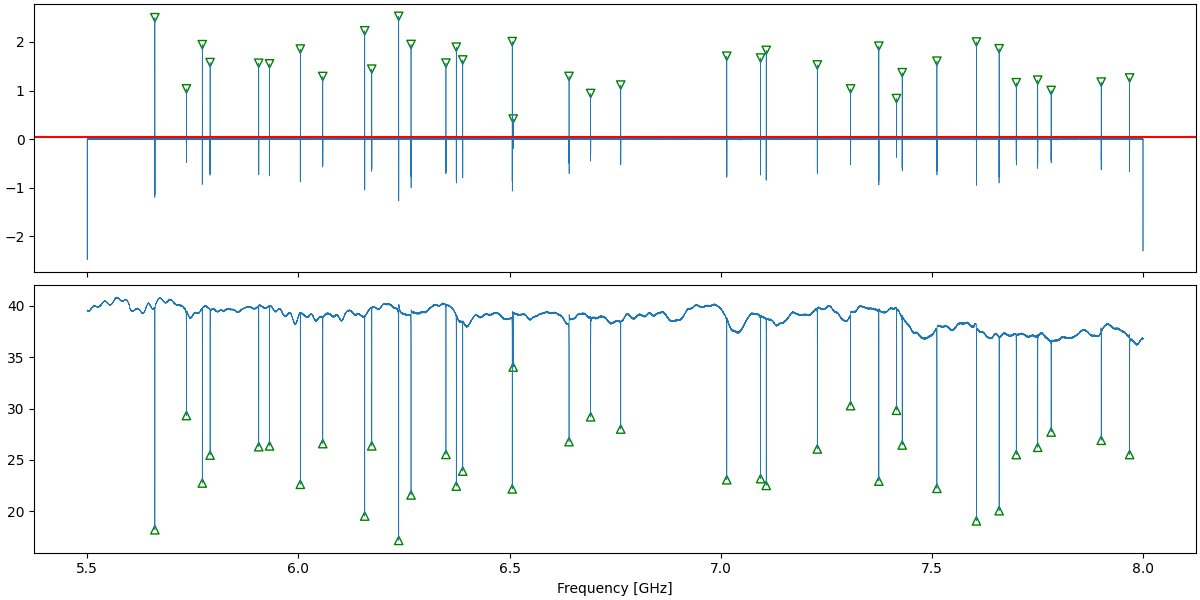

In [40]:
dir = './mapping_6x6/'
dark_s21 = np.load(glob(dir + '*dark.npy')[0])
freqs = np.load(glob(dir + '*freqs.npy')[0])
sw = 4 # even number
mph = 0.05
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['a'].plot(smooth_ds21)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, dark_s21, lw=.5)
ax['a'].axhline(mph, c='r')
# ax['b'].plot(s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
ax['a'].scatter(freqs[:-2][locs], heights, marker='v', c='None', edgecolor='g')
# ax['a'].scatter(freqs[locs[(locs[1:]-locs[:-1]) < 10]], heights, marker='v', c='None', edgecolor='r')
ax['b'].scatter(freqs[locs], dark_s21[locs], marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [61]:
yfiles = glob(dir + '*x0*.npy')
xfiles = glob(dir + '*y0*.npy')
nr_x = len(xfiles)
nr_y = len(yfiles)
nr_steps = int(np.amax((nr_x, nr_y)))
nr_kids = len(locs)
s21s = np.empty((nr_steps, 2, nr_kids))
s21s[:] = np.nan
s0 = dark_s21[locs]
sx0 = np.load(xfiles[0])[locs]
sy0 = np.load(yfiles[0])[locs]
for i, xfile in enumerate(xfiles):
    if i < len(xfiles):
        s21x = np.load(xfile)
        s21s[i, 0, :]  = s21x[locs] - sx0
    if i < len(yfiles):
        yfile = yfiles[i]
        s21y = np.load(yfile)
        s21s[i, 1, :]  = s21y[locs] - sy0 

In [128]:
sw = 2
dw = 4
medw = 3
mph = .25
mpw = 0
mpp = mph/2
smooth_s21s = np.empty((len(xfiles)+1, 2, len(locs)))
smooth_s21s[:] = np.nan
smooth_d2s21s = np.empty((len(xfiles)+6, 2, len(locs)))
smooth_d2s21s[:] = np.nan
window = np.ones(sw)/sw
dwindow = np.ones(dw)/dw
pos = np.empty((nr_kids, 2))
pos[:] = 0
semi_pos = np.empty((nr_kids, 2))
semi_pos[:] = 0
nr_good = 0
nr_semi = 0
bad = []
for i in range(nr_kids):
    powerx = s21s[:, 0, i]
    powerx = powerx[~np.isnan(powerx)]
    medpowerx = medfilt(powerx, medw)
    smoothpowerx = convolve(medpowerx, window, mode='full')
    smooth_s21s[:len(smoothpowerx), 0, i] = smoothpowerx
    d1x = np.diff(smoothpowerx, 1)
    d1xsmooth = convolve(d1x, dwindow, mode='full')
    d2x = np.diff(d1xsmooth, 1)
    d2x = convolve(d2x, dwindow, mode='full')
    smooth_d2s21s[:len(d2x), 0, i] = d2x

    powery = s21s[:, 1, i]
    powery = powery[~np.isnan(powery)]
    medpowery = medfilt(powery, medw)
    smoothpowery = convolve(medpowery, window, mode='full')
    smooth_s21s[:len(smoothpowery), 1, i] = smoothpowery
    d1y = np.diff(smoothpowery, 1)
    d1ysmooth = convolve(d1y, dwindow, mode='full')
    d2y = np.diff(d1ysmooth, 1)
    d2y = convolve(d2y, dwindow, mode='full')
    smooth_d2s21s[:len(d2y), 1, i] = d2y
    locx, propx = find_peaks(-d2x, height=mph, prominence=mpp, width=mpw)
    locy, propy = find_peaks(-d2y, height=mph, prominence=mpp, width=mpw)
    
    if len(locx)==1 and len(locy)==1:
        cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
        cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
        pos[i, 0] = cx
        pos[i, 1] = cy
        nr_good += 1
    # else:
    #     bad.append(i)
    elif len(locx)==1 or len(locy)==1:
        bad.append(i)
        if len(locx) == 1:
            cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
            semi_pos[i, 0] =  cx
            semi_pos[i, 1] = np.nanargmin(d2y)
        if len(locy) == 1:
            semi_pos[i, 0] = np.nanargmin(d2x)
            cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
            semi_pos[i, 1] =  cy
        nr_semi += 1
        print(semi_pos[i])
        # print('one peak at: ', i)
    else:
        # bad.append(i)
        pass
        # print('NO peak at: ', i)
print('good: ', nr_good)
# print('semi: ', nr_semi)
print('bad: ', len(bad))

[7. 2.]
good:  35
bad:  1


C:\Users\wilbertr\AppData\Local\Temp\ipykernel_13260\2095669108.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 0] = cx
C:\Users\wilbertr\AppData\Local\Temp\ipykernel_13260\2095669108.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 1] = cy
C:\Users\wilbertr\AppData\Local\Temp\ipykernel_13260\2095669108.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  semi_pos[i, 0] =  cx


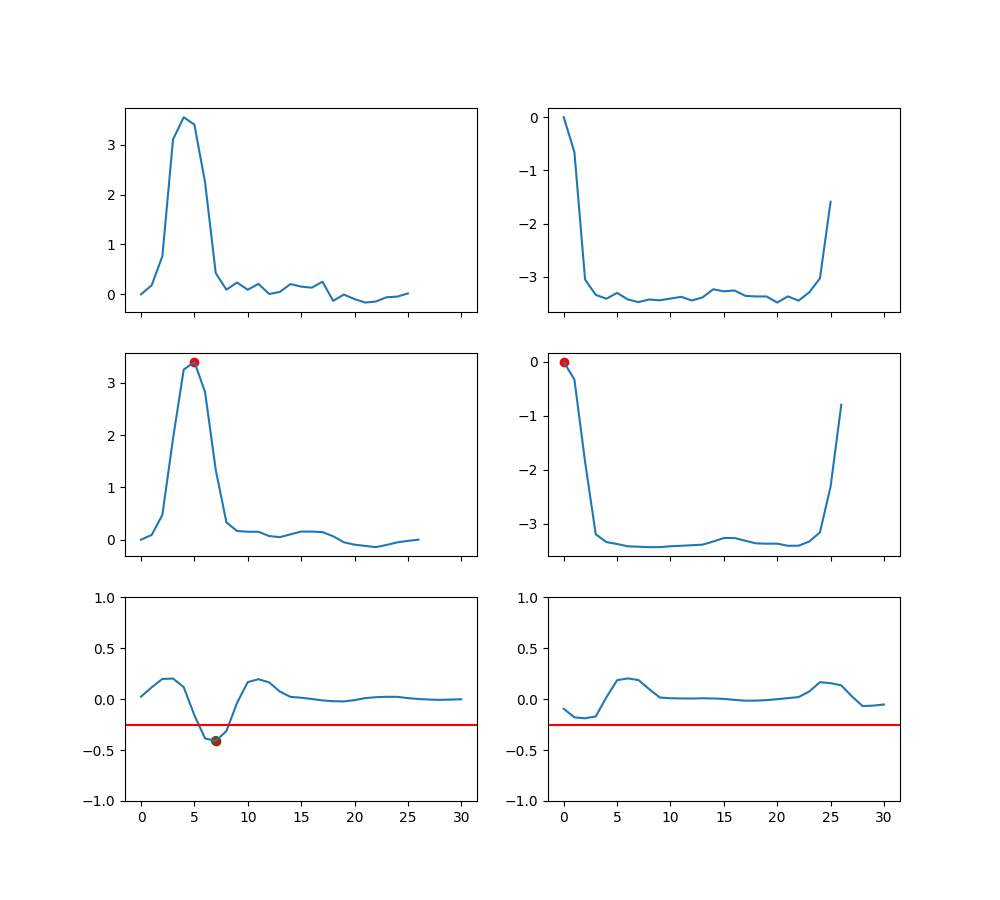

In [129]:
kid = bad[0]
x = s21s[:, 0, kid]
y = s21s[:, 1, kid]
xsmooth = smooth_s21s[:, 0, kid]
ysmooth = smooth_s21s[:, 1, kid]
d2xsmooth = smooth_d2s21s[:, 0, kid]
d2ysmooth = smooth_d2s21s[:, 1, kid]

fig, ax = plt.subplot_mosaic('ab;cd;ef', figsize=(10, 9), sharex=True)
ax['a'].plot(x)
ax['b'].plot(y)

ax['c'].plot(xsmooth)
ax['d'].plot(ysmooth)
ax['c'].scatter(np.nanargmax(xsmooth), np.nanmax(xsmooth), c='r')
ax['d'].scatter(np.nanargmax(ysmooth), np.nanmax(ysmooth), c='r')

ax['e'].plot(d2xsmooth)
ax['f'].plot(d2ysmooth)
ax['e'].axhline(-mph, c='r')
ax['f'].axhline(-mph, c='r')
locx, propx = find_peaks(-d2xsmooth, height=mph, prominence=mpp, width=mpw)
cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
locy, propy = find_peaks(-d2ysmooth, height=mph, prominence=mpp, width=mpw)
cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
ax['e'].scatter(locx, -propx['peak_heights'], c='r')
ax['f'].scatter(locy, -propy['peak_heights'], c='r')
ax['e'].set_ylim(-1, 1)
ax['f'].set_ylim(-1, 1)
ax['e'].scatter(cx, -propx['peak_heights'], c='None', edgecolor='g')
ax['f'].scatter(cy, -propy['peak_heights'], c='None', edgecolor='g')

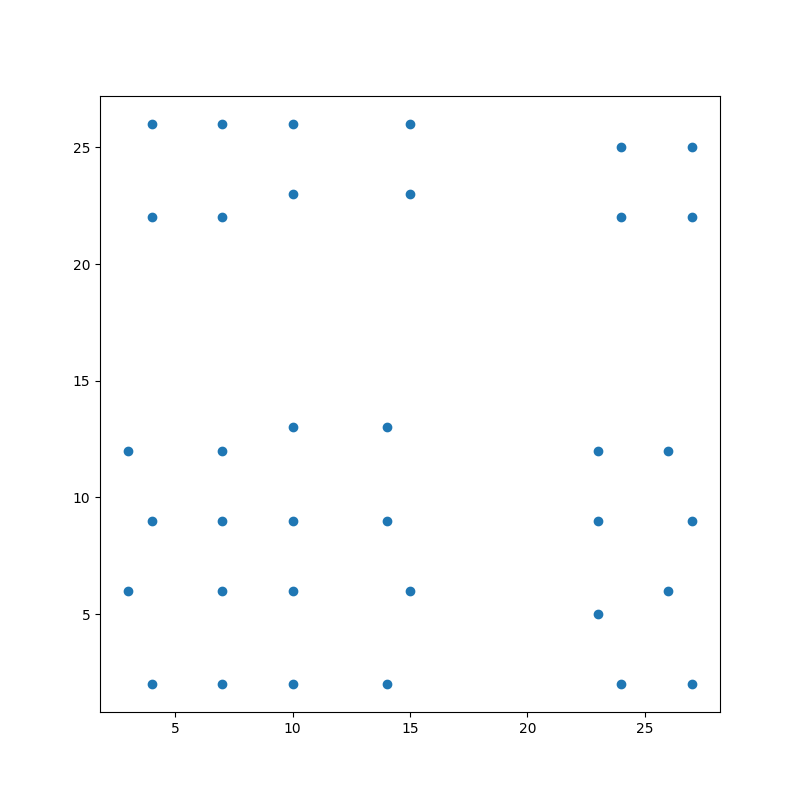

In [130]:
fig, ax = plt.subplots(figsize=(8, 8))
full_pos = pos + semi_pos
ax.scatter(*full_pos.T)
# ax.scatter(*semi_pos.T, c='None', edgecolor='orange')

In [ ]:
fs = freqs[locs]*1e9
dfs = fs[1:]-fs[:-1]
Q = 5e4
F0 = 6e9
fwhm = F0 / Q
dfwhms = dfs / fwhm
fig, ax = plt.subplots()
_ = ax.hist(dfs*1e-6, bins='auto')
ax.set_xlabel('$df=f^{i+1}_0-f^{i}_0$')
ax.set_ylabel('counts')
ax.set_xlim(0, 50)
# _ = ax.hist(dfwhms, bins='auto')
# ax.set_xlim(0, 500)